In [1]:
print("Starting imports...")
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

print("Importing few...")
import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux

from few.utils.geodesic import get_fundamental_frequencies

from few.utils.constants import YRSID_SI

import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

print("Importing GWfuncs...")
import GWfuncs
# import gc
# import pickle
print("Importing cupy...")
import cupy as cp

print("Configuring few...")
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")

Starting imports...
Importing few...
Importing GWfuncs...
Importing cupy...
Configuring few...


In [2]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


In [3]:
# Initialize parameters and backend
N_traj = 500
use_gpu = True 
T = 1 # year
T_sec = T * YRSID_SI
dt = 10
delta_T = T_sec / N_traj # define coarser sampling time step

In [30]:
delta_T, T

(63116.29952709119, 1)

In [4]:
# Waveform generation attributes
# NOTE: honestly the only diff is in the EMRIInspiral class, which has a different npoints flag
# otherwise only need to initialize waveform_gen with FastKerrEccentricEquatorialFlux
# TODO: ? 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu, npoints = N_traj) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [5]:
#Generating data (true)

m1_o = 1e6
m2_o = 1e1
a_o = 0.5
p0_o = 9.5
e0_o = 0.2
xI_o = 1.0
theta_o = np.pi/3  # polar viewing angle
phi_o = np.pi/4  # azimuthal viewing angle
dist = 1 # Gpc

In [6]:
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1_o, m2_o, a_o, p0_o, e0_o, xI_o, T=T, dt=delta_T, upsample=True) 


In [7]:
# Generate mode frequencies
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a_o, p, e, x) #could use GPU here but im running to mismatch probs


In [8]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [9]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [10]:
gw_frequencies_per_mode = []

for idx in range(len(mode_labels)):
    # TODO: do convert this so everything is in either CPU/GPU?
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)# Generate mode frequencies

In [11]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]

    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

In [12]:
gwf = GWfuncs.GravWaveAnalysis(T, dt)
factor = gwf.dist_factor(dist, m2_o)

In [13]:
# Get amplitudes along trajectory
teuk_modes = amp(a_o, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta_o, phi_o).copy()[amp.inverse_lm]

In [14]:
mode_selector = GWfuncs.ModeSelector(teuk_modes=teuk_modes, amp=amp, gw_frequencies=gw_frequencies_per_mode, gw_phases= gw_phase_per_mode, delta_T=delta_T, factor=factor, gwf=gwf)

In [17]:
m0mask = amp.m_arr_no_mask != 0

total_power = gwf.calc_power(teuk_modes, ylms, m0mask)
total_power_cpu = total_power.get()
M_mode = 50
mp = list(zip(mode_labels, total_power_cpu)) 
# Sort by power and pick top M modes
mp_sorted = sorted(mp, key=lambda x: x[1], reverse=True)[:M_mode]
mp_modes = [x[0] for x in mp_sorted]
mp_power = [x[1] for x in mp_sorted]

In [25]:
total_power_cpu

array([4.08525776e-37, 4.28041674e-36, 7.86661176e-37, ...,
       4.55514865e-32, 4.55659483e-33, 6.53330001e-32])

In [24]:
mp_modes  

['(2,2,0)',
 '(2,2,1)',
 '(2,2,-1)',
 '(3,3,0)',
 '(3,3,1)',
 '(2,2,2)',
 '(3,3,-1)',
 '(2,1,0)',
 '(2,-2,0)',
 '(3,3,2)',
 '(4,4,1)',
 '(2,-2,1)',
 '(2,2,3)',
 '(4,4,2)',
 '(4,4,-1)',
 '(4,4,0)',
 '(2,1,1)',
 '(3,3,3)',
 '(2,-1,0)',
 '(2,-2,-1)',
 '(3,-3,0)',
 '(4,4,3)',
 '(3,-3,1)',
 '(5,5,1)',
 '(5,5,2)',
 '(2,-2,2)',
 '(3,3,-2)',
 '(3,2,0)',
 '(2,0,-1)',
 '(2,0,1)',
 '(2,2,-2)',
 '(5,5,-1)',
 '(2,-1,1)',
 '(3,-3,-1)',
 '(2,2,4)',
 '(3,-2,0)',
 '(3,3,4)',
 '(5,5,3)',
 '(4,4,-2)',
 '(3,2,1)',
 '(2,1,2)',
 '(3,-3,2)',
 '(4,4,4)',
 '(3,-2,1)',
 '(4,-4,1)',
 '(6,6,2)',
 '(3,-1,0)',
 '(5,5,0)',
 '(5,5,-2)',
 '(5,5,4)']

In [23]:
mp_power

[16.46865454281919,
 4.7659650803333635,
 1.6149074449428453,
 0.8744987496064003,
 0.7455900716447382,
 0.5921394976477974,
 0.30108583364716474,
 0.2571023073351396,
 0.2033167227508538,
 0.19174712260722634,
 0.090217497140162,
 0.05883907506584388,
 0.051272646093899504,
 0.04279540086729234,
 0.041540387660283465,
 0.036454457995534185,
 0.03441100904914794,
 0.02943256425259565,
 0.028566923037237707,
 0.019937128949911634,
 0.010796280859338255,
 0.01061118176842318,
 0.00920481569931774,
 0.008806627853982597,
 0.007459687813974337,
 0.007310364168491313,
 0.0068617440112591094,
 0.005838009764159505,
 0.005103348229327582,
 0.005103348229327582,
 0.005096134411909705,
 0.004651485811924386,
 0.003823445449905324,
 0.0037171090573723978,
 0.003623935359153703,
 0.003531635536343405,
 0.003351229358929294,
 0.002841108432008705,
 0.00275611963570477,
 0.002735971380782294,
 0.0023851344064042884,
 0.0023672484272497037,
 0.0018110292439100272,
 0.0016550937982510172,
 0.00111379

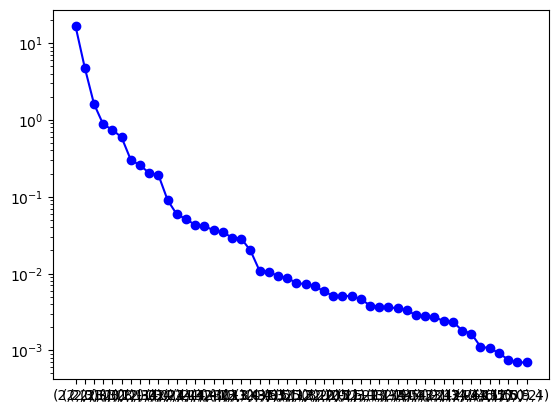

In [21]:
plt.plot(mp_modes, mp_power, marker='o', linestyle='-', color='b')
plt.yscale('log')
plt.show()

In [18]:
selected_modes, selected_indices, selected_labels, counts, final_ips = mode_selector.select_modes_power(
    power_values=mp_power, mode_labels=mp_modes, original_mode_labels=mode_labels, M_sel=10, inner_threshold=0.01
)

Step 0: Selected strongest mode h_0: (2,2,0) with power value 1.6469e+01
Using power inner product calculation.
Inner product: 819.181596

--- Iteration 1 ---
Currently have 1 selected modes, target is 10
Candidate mode h_j': (2,2,1) with power value 4.7660e+00
  Calculating inner product with selected mode [1165] and hj_prime_idx: 1166
0.0021594627596660163
  calc_inner with selected mode 0 ((2,2,0)): 0.002159
  ACCEPTED: Max inner product 0.002159 < 0.01
  Added mode: (2,2,1) (Total selected: 2)

--- Iteration 2 ---
Currently have 2 selected modes, target is 10
Candidate mode h_j': (2,2,-1) with power value 1.6149e+00
  Calculating inner product with selected mode [1165] and hj_prime_idx: 1164
0.0021440787661995133
  calc_inner with selected mode 0 ((2,2,0)): 0.002144
  Calculating inner product with selected mode [1166] and hj_prime_idx: 1164
0.00231434865538158
  calc_inner with selected mode 1 ((2,2,1)): 0.002314
  ACCEPTED: Max inner product 0.002314 < 0.01
  Added mode: (2,2,-1)

In [26]:
teuk_modes

array([[ 1.55001444e-19-1.17375858e-19j, -5.10407779e-19+2.23870615e-19j,
        -4.01495449e-19-1.41155523e-19j, ...,
        -3.19075120e-16-2.84958141e-16j,  3.73706358e-17-1.00998204e-16j,
        -6.49495176e-16+6.16414410e-16j],
       [ 1.54321285e-19-1.16800190e-19j, -5.11539879e-19+2.24795711e-19j,
        -3.98992159e-19-1.39659015e-19j, ...,
        -3.19828954e-16-2.87772164e-16j,  3.76958783e-17-1.01696628e-16j,
        -6.46055613e-16+6.14980894e-16j],
       [ 1.53630749e-19-1.16220834e-19j, -5.12641706e-19+2.25704781e-19j,
        -3.96475881e-19-1.38158373e-19j, ...,
        -3.20552137e-16-2.90564482e-16j,  3.80173457e-17-1.02385336e-16j,
        -6.42573868e-16+6.13511168e-16j],
       ...,
       [ 2.63993836e-20+4.63176292e-21j,  4.49835125e-20-7.28143936e-21j,
        -1.23467946e-20+2.29361687e-22j, ...,
         7.79997761e-18-5.81217781e-17j, -3.73822751e-18-1.50127120e-17j,
         3.11362799e-17+1.41093742e-17j],
       [ 2.53478014e-20+4.59270345e-21j,  4.

In [27]:
ylms

array([2.89705652e-01+0.j        , 2.89705652e-01+0.j        ,
       2.89705652e-01+0.j        , ..., 1.08511120e-17-0.03544242j,
       1.08511120e-17-0.03544242j, 1.08511120e-17-0.03544242j])

In [28]:
teuk_modes.shape

(500, 6993)

In [29]:
delta_T, T

(63116.29952709119, 1)